In [2]:
import pandas as pd
import torch
import numpy as np
import os
from Bio import SeqIO
import matplotlib.pyplot as plt
from CODE.AttentionDCA_python.src.plot_functions import attention_heads
cwd = os.getcwd()

ImportError: cannot import name 'create_attention_masks' from 'CODE.AttentionDCA_python.src.model' (/home/ale_durso/Documents/EPFL/MA5/master_project/Attention DCA/CODE/AttentionDCA_python/src/model.py)

In [5]:
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

colors_cmap = ["#A21622","#FE5D21","#F9DB6D","#E4F7DE","#81C8D9","#4D5AFF","#13152D"]
colors_palette = ["#4D5AFF","#FE5D21","#F6C928","#02B64D","#EFABFF","#E072A4","#337064","#A21622"]
cmap = LinearSegmentedColormap.from_list("mycmap", colors_cmap)
cmap_palette=sns.color_palette(colors_cmap)

mypalette=sns.color_palette(colors_palette)

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rc("text", usetex=True)
plt.rc('font', size=12)  
mpl.rc("text.latex", preamble=r"\usepackage{amsmath}")

#mpl.rcParams['xtick.major.pad'] = -3    # if you want to specify the pixels between the ticks and the labels
#mpl.rcParams['ytick.major.pad'] = -4    # if you want to specify the pixels between the ticks and the labels

fig_size_half = (3.1, 2.4)                   # (width, height in inches) -> check that it fits perfectly on the page the way you want it to
figsize_full = (6,5)
fig_margins = {
    "top": 0.9,                         # percentage from figure to top
    "bottom": 0.1,                      # percentage from figure to bottom
    "left": 0.1,                        # percentage from figure to left
    "right": 0.95,                      # percentage from figure to right
    "wspace": 0.4,                      # weird thing to control width distribution of spacing when using multiple axes
    "hspace": 0.4,                      # weird thing to control height distribution of spacing when using multiple axes
}

fig_margins_half ={
    "left": 0.18,
    "bottom": 0.2, 
    "right": 0.94, 
    "top": 0.88, 
    "wspace": 0.8, 
    "hspace": 0.3
}
#import os
#os.environ["PATH"] += os.pathsep + "/Library/TeX/texbin" # jupyter notebook doesn't know where to find latex (at least for me), so you need to tell it where to look
#print(os.getenv("PATH"))

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams.update({'font.size': 12})
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{bm}'

### Divide train and test sequences

In [6]:
# MSA_train, MSA_test, IDs_train, IDs_test = pick_training_MSA("./CODE/DataAttentionDCA/HK-RR/HK-RR_174.fasta", 20000, return_IDs=True, return_test=True)
# write_fasta("./CODE/DataAttentionDCA/HK-RR/HK-RR_174_train.fasta", MSA_train, IDs_train)
# write_fasta("./CODE/DataAttentionDCA/HK-RR/HK-RR_174_test.fasta", MSA_test, IDs_test)

### Load couplings

In [7]:
def read_tensor_from_txt(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    
    # Read the dimensions from the first line
    dims = list(map(int, lines[0].strip().split()))
    
    # Initialize a list to hold the tensor data
    tensor_data = []
    
    current_slice = []
    for line in lines[1:]:
        line = line.strip()
        if line.startswith("Slice"):
            if current_slice:  # If there is an existing slice, save it
                tensor_data.append(current_slice)
                current_slice = []
        elif line:  # Process non-empty lines
            current_slice.append(list(map(float, line.split(','))))
    
    if current_slice:  # Append the last slice
        tensor_data.append(current_slice)
    
    # Convert the list back into a tensor with the original dimensions
    tensor = torch.tensor(tensor_data).view(*dims)
    return tensor

In [5]:
H = 150
d = 23
loss_type = "without_J"
family = "HK-RR" # CHANGE
family="hsp70"

#dist_map_file = cwd + "/CODE/DataAttentionDCA/{family}/HK-RR_old_preprocessed.map".format(family=family) # CHANGE
dist_map_file=cwd + "/CODE/DataAttentionDCA/{family}/hsp70.map".format(family=family)

epochs = 300

#folder = "HK-RR_174_train" # CHANGE
folder = "{H}_{d}_{family}_{losstype}_{epochs}".format(H=H, d=d, family=family, losstype=loss_type, epochs=epochs)
K = read_tensor_from_txt(cwd + "/results/" + folder + "/K_tensor.txt")
Q = read_tensor_from_txt(cwd + "/results/" + folder + "/Q_tensor.txt")
V = read_tensor_from_txt(cwd + "/results/" + folder + "/V_tensor.txt")

print(V.shape)

V=V[:,1:,1:]
A = attention_heads(Q, K, V, sym=True)

torch.Size([150, 22, 22])


### Check train couplings

c:\Users\lisag\OneDrive - epfl.ch\Documenti\PhD\Attention-DCA\CODE\AttentionDCA_python\src\plot_functions.py:381: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


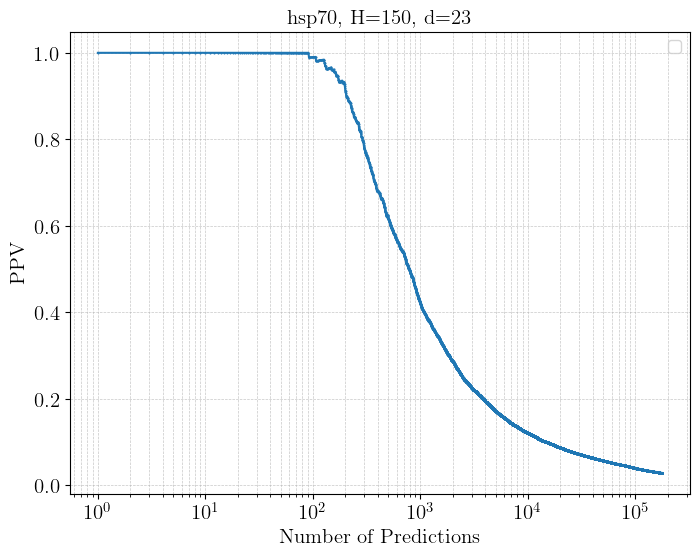

In [6]:
from CODE.AttentionDCA_python.src.dcascore import score, compute_PPV_from_map
from CODE.AttentionDCA_python.src.plot_functions import graphPPV

ranking, _ = score(Q, K, V)
PPVs = [compute_PPV_from_map(ranking, dist_map_file, cutoff=8)]  

labels = ["AttentionDCA"]
figtitle = "{family}, H={H}, d={d}".format(family=family, H=H, d=d)
graphPPV(PPVs, labels, figtitle, fig_size=(8, 6), colors=["b"], fs=15)

V = np.array(V)
A = np.array(A)

### Load test sequences (they need to be different from seqs with trained on!!!)

In [8]:
# Fasta functions

tokens_protein = "ACDEFGHIKLMNPQRSTVWY-"

standard_amino_acids = np.array(
    [
        "A",
        "C",
        "D",
        "E",
        "F",
        "G",
        "H",
        "I",
        "K",
        "L",
        "M",
        "N",
        "P",
        "Q",
        "R",
        "S",
        "T",
        "V",
        "W",
        "Y",
        "-"
    ],
    dtype=np.str_,
 )

def paired_fasta_to_labeled_array(fasta_name,L_A, nb_samples=1, tokenize=False, tokens=tokens_protein):
    """
    Gets fasta file with paired sequences and returns two numpy arrays with labels for the species and for the partners

    ### Parameters:
    - fasta_name: str, name of the fasta file with the paired sequences (with path). 
                  the description of the sequences should be in the format "entry1|species|...//entry2|species|..."   
    - L_A: int, length of the sequences of family A
    - nb_samples: sequences in input MSA should be generated using one-to-many (nb_samples), A to B interactions

    ### Returns:
    - seqsA: np.array, array with the sequences of family A
    - seqsB: np.array, array with the sequences of family B
    The first element of each sequence is the label of the species and the second element is the label of the sequence (partners have the same label after integer division //nb_samples)
    """

    seqs=[]
    IDs=[]
    for record in SeqIO.parse(fasta_name, "fasta"):
        seqs.append(record.seq)
        IDs.append(record.description)
    seqs=np.array(seqs)

    MSA_A=seqs[:,:L_A]
    MSA_B=seqs[:,L_A:]

    if tokenize==True:
        MSA_A=tokenize_seqs(MSA_A, tokens=tokens).astype(np.uint8)
        MSA_B=tokenize_seqs(MSA_B, tokens=tokens).astype(np.uint8)

    # add labels in front of sequences in MSA_A and MSA_B:
    MSA_A_label=np.insert(MSA_A,0,0,axis=1)
    MSA_B_label=np.insert(MSA_B,0,0,axis=1)

    MSA_A_label=np.insert(MSA_A_label,0,0,axis=1)
    MSA_B_label=np.insert(MSA_B_label,0,0,axis=1)

    MSA_A_label=np.array(MSA_A_label,object) # otherwise it doesn't work
    MSA_B_label=np.array(MSA_B_label,object)

    species_dict={}
    counter=0
    for i in range(MSA_A.shape[0]):
        sp=IDs[i].split("|")[1]

        if sp not in species_dict.keys():
            species_dict[sp]=counter
            counter+=1

        MSA_A_label[i,0]=species_dict[sp]
        MSA_B_label[i,0]=species_dict[sp]

        pair_index=i//nb_samples
        MSA_A_label[i,1]=str(pair_index)
        MSA_B_label[i,1]=str(i)

    return MSA_A_label, MSA_B_label

def encode_sequence_lore(sequence : str, tokens : str=tokens_protein) -> list:
    """Takes a string sequence in input an returns the numeric encoding.

    Args:
        sequence (str): Input sequence.
        tokens (str): Alphabet to be used for the encoding.

    Returns:
        list: Encoded sequence.
    """
    letter_map = {l : n for n, l in enumerate(tokens)}
    return np.array([letter_map[l] for l in sequence])

def tokenize_seqs(seqs, tokens=tokens_protein):
    seqs=seqs.copy()
    seqs=seqs.astype(str)
    seqs_str = np.array(["".join(seqs[i]) for i in range(len(seqs))])
    seqs_tks = np.vectorize(
        encode_sequence_lore, excluded=["tokens"], signature="(), () -> (n)"
    )(seqs_str, tokens)

    return seqs_tks

In [8]:
L_A=377 # CHANGE
MSA_A_label, MSA_B_label=paired_fasta_to_labeled_array("./CODE/DataAttentionDCA/hsp70/hsp70_test_new_3000.fasta",L_A=L_A) # CHANGE
#MSA_A_label, MSA_B_label=paired_fasta_to_labeled_array("./CODE/DataAttentionDCA/HK-RR/HK-RR_174_test.fasta",L_A=64) # CHANGE

MSA_A_label[:,1]=MSA_A_label[:,1].astype(np.uint16) # Needed for numba
MSA_B_label[:,1]=MSA_B_label[:,1].astype(np.uint16)

### Functions

In [9]:
from numba import prange, jit

def_val=10000

@jit(nopython=True) #parallelise using numba
def interaction_energy_pair_species_label(
    seqA, seqB, A, V, default_value=def_val
):
    """
    Takes labeled TOKENIZED sequences from interacting families A and B and calculates interaction energy between them.
    Input sequences should have one label for interaction pair and one label for species.
    If they're not from the same species, the interaction energy is set to default_value
    """
    #print("interaction_energy")

    labelsA=seqA[:2]
    labelsB=seqB[:2]
    seqA=seqA[2:]
    seqB=seqB[2:]

    seqtot=np.concatenate((seqA,seqB))
    L = len(seqtot)

    L_A = len(seqA)
    
    if labelsA[0] != labelsB[0]:
        return default_value

    else:
        E_int = 0
        for i in range(L_A,L):
            ind_a = seqtot[i]
            for j in range(L_A):
                ind_b = seqtot[j]

                E_int += np.sum(A[:, i, j] * V[:, ind_a, ind_b]) # J(i,j+L_A,ind_a,ind_b,A,V)

    return E_int

@jit(nopython=True) #parallelise using numba
def full_energy_pair_species_label(
    seqA, seqB, A, V, default_value=def_val
):
    """
    Takes labeled TOKENIZED sequences from interacting families A and B and calculates interaction energy between them.
    Input sequences should have one label for interaction pair and one label for species.
    If they're not from the same species, the interaction energy is set to default_value
    """
    #print("full_energy")
    labelsA=seqA[:2]
    labelsB=seqB[:2]
    seqA=seqA[2:]
    seqB=seqB[2:]

    seqtot=np.concatenate((seqA,seqB))
    L = len(seqtot)

    if labelsA[0] != labelsB[0]:
        E_int = default_value

    else:
        E_int = 0
        for i in range(L):
            ind_a = seqtot[i]
            for j in range(i):
                #print(i,j)
                ind_b = seqtot[j]

                # if ind_a == len(symbols) - 1 or ind_b == len(symbols) - 1:
                #     continue
                
                E_int += np.sum(A[:, i, j] * V[:, ind_a, ind_b]) # J(i,j,ind_a,ind_b,A,V)
    
    return E_int


@jit(nopython=True) #parallelise using numba
def energy_no_int_pair_species_label(
    seqA, seqB, A, V, default_value=def_val
):
    """
    Takes labeled TOKENIZED sequences from interacting families A and B and calculates sum of the energies without interaction part.
    Input sequences should have one label for interaction pair and one label for species.
    If they're not from the same species, the interaction energy is set to default_value
    """
    #print("energy_no_int")
    labelsA=seqA[:2]
    labelsB=seqB[:2]
    seqA=seqA[2:]
    seqB=seqB[2:]

    seqtot=np.concatenate((seqA,seqB))
    L = len(seqtot)

    L_A = len(seqA)

    if labelsA[0] != labelsB[0]:
        return default_value

    else:
        E = 0
        for i in range(L_A):
            ind_a = seqtot[i]
            for j in range(i):
                #print(i,j)
                ind_b = seqtot[j]
                E += np.sum(A[:, i, j] * V[:, ind_a, ind_b]) # J(i,j+L_A,ind_a,ind_b,A,V)

        for i in range(L_A,L):
            ind_a = seqtot[i]
            for j in range(L_A,i):
                #print(i,j)
                ind_b = seqtot[j]
                E += np.sum(A[:, i, j] * V[:, ind_a, ind_b])

    return E

@jit(nopython=True, parallel=True) #parallelise using numba
def energy_calculation_tks_species_label(seqsA, seqsB, A, V):
    """
    seqsA and seqsB must be in tokens, not amino acid symbols!! (and unlabeled)
    """
    N_A=len(seqsA)
    N_B=len(seqsB)
    scores = np.zeros((N_A, N_B), dtype=np.float32)
    for i in prange(N_A):
        seqA=seqsA[i]
        for j in range(N_B):
            seqB=seqsB[j]
            scores[i,j] = interaction_energy_pair_species_label(seqA, seqB, A, V)
    return scores

@jit(nopython=True, parallel=True) #parallelise using numba
def energy_calculation_tks_species_label_full(seqsA, seqsB, A, V):
    """
    seqsA and seqsB must be in tokens, not amino acid symbols!! (and unlabeled)
    """
    N_A=len(seqsA)
    N_B=len(seqsB)
    scores = np.zeros((N_A, N_B), dtype=np.float32)
    for i in prange(N_A):
        seqA=seqsA[i]
        for j in range(N_B):
            seqB=seqsB[j]
            scores[i,j] = full_energy_pair_species_label(seqA, seqB, A, V)
    return scores


@jit(nopython=True, parallel=True) #parallelise using numba
def energy_calculation_tks_species_label_noint(seqsA, seqsB, A, V):
    """
    seqsA and seqsB must be in tokens, not amino acid symbols!! (and unlabeled)
    """
    N_A=len(seqsA)
    N_B=len(seqsB)
    scores = np.zeros((N_A, N_B), dtype=np.float32)
    for i in prange(N_A):
        seqA=seqsA[i]
        for j in range(N_B):
            seqB=seqsB[j]
            E=energy_no_int_pair_species_label(seqA, seqB, A, V)
            scores[i,j] = E
    return scores



def prep_spectrum_plots_energy_species(seqsA,seqsB,A, V):
    
    seqsA_tks=tokenize_seqs(seqsA[:,2:], tokens=tokens_protein)
    seqsB_tks=tokenize_seqs(seqsB[:,2:], tokens=tokens_protein)

    seqsA_all=np.concatenate((seqsA[:,:2], seqsA_tks), axis=1)
    seqsA_all = seqsA_all.astype(np.uint16)
    seqsB_all=np.concatenate((seqsB[:,:2], seqsB_tks), axis=1)
    seqsB_all = seqsB_all.astype(np.uint16)

    print("tokenized seqs")
    
    score=energy_calculation_tks_species_label(seqsA_all,seqsB_all, A, V)
    score_save = score.copy()
    print("energy calculated")

    nbseqsA, nbseqsB = np.shape(score)
    label_B=np.zeros(np.shape(score), dtype=np.uint16)
    correct_energies=np.zeros(np.shape(score), dtype=np.float64)

    for i in prange(nbseqsA):
        for j in range(nbseqsB):
            label_B[i,j]=j
            correct_energies[i,j]=1 if seqsA_all[i,0]==seqsB_all[j,0] and seqsA_all[i,1]==seqsB_all[j,1] else 0

    label_B=label_B.flatten()
    correct_energies=correct_energies.flatten()
    score=score.flatten()  

    return label_B, score, correct_energies, score_save

def prep_spectrum_plots_energy_species_full(seqsA,seqsB,A, V):
    
    seqsA_tks=tokenize_seqs(seqsA[:,2:], tokens=tokens_protein)
    seqsB_tks=tokenize_seqs(seqsB[:,2:], tokens=tokens_protein)

    seqsA_all=np.concatenate((seqsA[:,:2], seqsA_tks), axis=1)
    seqsA_all = seqsA_all.astype(np.uint16)
    seqsB_all=np.concatenate((seqsB[:,:2], seqsB_tks), axis=1)
    seqsB_all = seqsB_all.astype(np.uint16)

    print("tokenized seqs")
    
    score=energy_calculation_tks_species_label_full(seqsA_all,seqsB_all, A, V)
    score_save=score.copy()
    print("energy calculated")

    nbseqsA, nbseqsB = np.shape(score)
    label_B=np.zeros(np.shape(score), dtype=np.uint16)
    correct_energies=np.zeros(np.shape(score), dtype=np.float64)

    for i in prange(nbseqsA):
        for j in range(nbseqsB):
            label_B[i,j]=j
            correct_energies[i,j]=1 if seqsA_all[i,0]==seqsB_all[j,0] and seqsA_all[i,1]==seqsB_all[j,1] else 0

    label_B=label_B.flatten()
    correct_energies=correct_energies.flatten()
    score=score.flatten()  

    return label_B, score, correct_energies, score_save

def prep_spectrum_plots_energy_species_noint(seqsA,seqsB,A, V):
    
    seqsA_tks=tokenize_seqs(seqsA[:,2:], tokens=tokens_protein)
    seqsB_tks=tokenize_seqs(seqsB[:,2:], tokens=tokens_protein)

    seqsA_all=np.concatenate((seqsA[:,:2], seqsA_tks), axis=1)
    seqsA_all = seqsA_all.astype(np.uint16)
    seqsB_all=np.concatenate((seqsB[:,:2], seqsB_tks), axis=1)
    seqsB_all = seqsB_all.astype(np.uint16)

    print("tokenized seqs")
    
    score=energy_calculation_tks_species_label_noint(seqsA_all,seqsB_all, A, V)
    
    print("energy calculated")

    nbseqsA, nbseqsB = np.shape(score)
    label_B=np.zeros(np.shape(score), dtype=np.uint16)
    correct_energies=np.zeros(np.shape(score), dtype=np.float64)

    for i in prange(nbseqsA):
        for j in range(nbseqsB):
            label_B[i,j]=j
            correct_energies[i,j]=1 if seqsA_all[i,0]==seqsB_all[j,0] and seqsA_all[i,1]==seqsB_all[j,1] else 0

    label_B=label_B.flatten()
    correct_energies=correct_energies.flatten()
    score=score.flatten()  

    return label_B, score, correct_energies

In [10]:
label_B, score, correct_energies = prep_spectrum_plots_energy_species(MSA_A_label,MSA_B_label,A, V)
df_energy=pd.DataFrame({'label B':label_B, 'score':score, 'correct':correct_energies})

tokenized seqs
energy calculated


In [11]:
correct_scores = df_energy[df_energy['correct'] == True]['score'].values
incorrect_scores = df_energy[df_energy['correct'] == False]['score'].values
incorrect_scores = incorrect_scores[incorrect_scores < def_val]

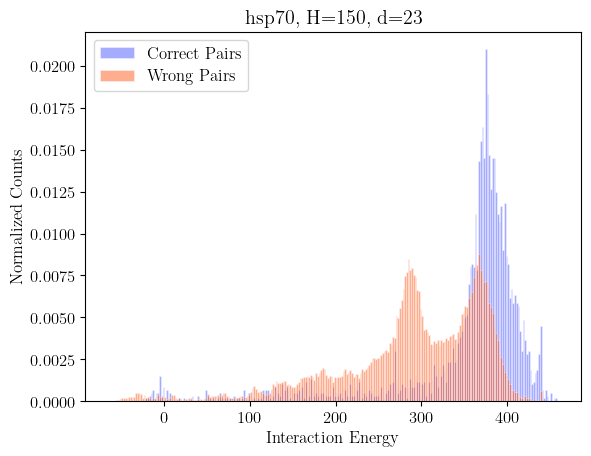

In [12]:
bin_width = 2

min_bins=min(min(correct_scores), min(incorrect_scores))
max_bins=max(max(correct_scores), max(incorrect_scores))
bins=np.arange(min_bins,max_bins+bin_width,bin_width)

plt.figure()
plt.hist(correct_scores, bins=bins, alpha=0.5, label='Correct Pairs', color=mypalette[0], density=True, edgecolor='white', linewidth=0.5)
plt.hist(incorrect_scores, bins=bins, alpha=0.5, label='Wrong Pairs', color=mypalette[1], density=True, edgecolor='white', linewidth=0.5)
plt.xlabel("Interaction Energy")
plt.ylabel("Normalized Counts")
plt.legend()#bbox_to_anchor=(0.5, 0.7))
plt.title("{family}, H={H}, d={d}".format(family=family, H=H, d=d))
plt.savefig('interaction_energy_scores_species_{family}_{H}_{d}_L_A={L_A}.pdf'.format(family=family, H=H, d=d, L_A=L_A))
plt.show()

In [13]:
label_B_full, score_full, correct_energies_full = prep_spectrum_plots_energy_species_full(MSA_A_label,MSA_B_label,A, V)
df_energy_full=pd.DataFrame({'label B':label_B_full, 'score':score_full, 'correct':correct_energies_full})

tokenized seqs
energy calculated


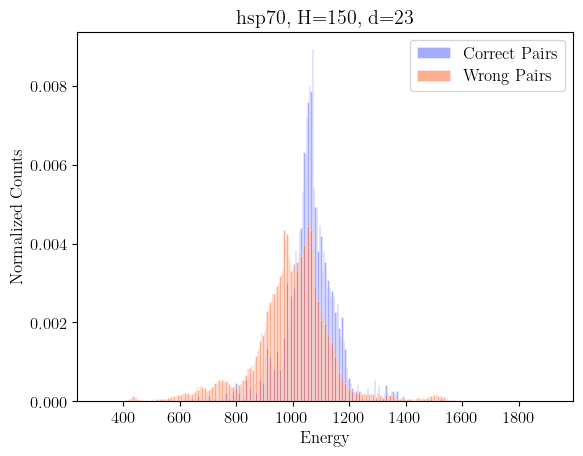

In [14]:
correct_scores_full = df_energy_full[df_energy_full['correct'] == True]['score'].values
incorrect_scores_full = df_energy_full[df_energy_full['correct'] == False]['score'].values
incorrect_scores_full = incorrect_scores_full[incorrect_scores_full < def_val]

bin_width_full = 5

min_full=min(min(correct_scores_full), min(incorrect_scores_full))
max_full=max(max(correct_scores_full), max(incorrect_scores_full))
bins_full=np.arange(min_full,max_full+bin_width_full,bin_width_full)

plt.figure()
plt.hist(correct_scores_full, bins=bins_full, alpha=0.5, color=mypalette[0], label='Correct Pairs', density=True, edgecolor='white', linewidth=0.5)
plt.hist(incorrect_scores_full, bins=bins_full, alpha=0.5, color=mypalette[1], label='Wrong Pairs', density=True, edgecolor='white', linewidth=0.5)
plt.xlabel("Energy")
plt.ylabel("Normalized Counts")
plt.legend()#bbox_to_anchor=(0.5, 0.7))
plt.title("{family}, H={H}, d={d}".format(family=family, H=H, d=d))
plt.savefig('full_energy_scores_species_{family}_{H}_{d}_L_A={L_A}.pdf'.format(family=family, H=H, d=d, L_A=L_A))
plt.show()

### Without interaction part

In [15]:
label_B_noint, score_noint, correct_energies_noint = prep_spectrum_plots_energy_species_noint(MSA_A_label,MSA_B_label,A, V)
df_energy_noint=pd.DataFrame({'label B':label_B_noint, 'score':score_noint, 'correct':correct_energies_noint})

tokenized seqs
energy calculated


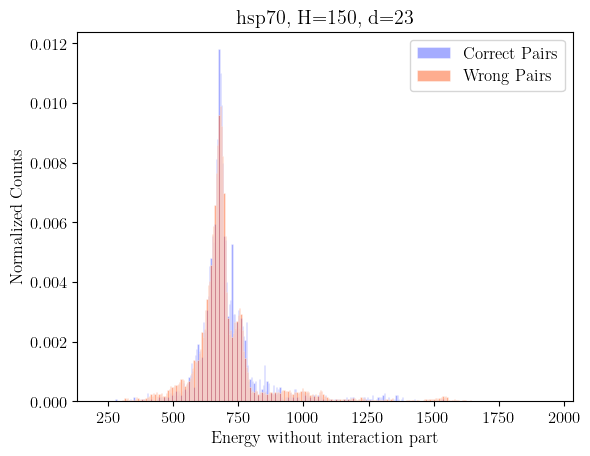

In [16]:
correct_scores_noint = df_energy_noint[df_energy_noint['correct'] == True]['score'].values
incorrect_scores_noint = df_energy_noint[df_energy_noint['correct'] == False]['score'].values
incorrect_scores_noint = incorrect_scores_noint[incorrect_scores_noint < def_val]

bin_width_noint = 5

min_noint=min(min(correct_scores_noint), min(incorrect_scores_noint))
max_noint=max(max(correct_scores_noint), max(incorrect_scores_noint))
bins_noint=np.arange(min_noint,max_noint+bin_width_noint,bin_width_noint)

plt.figure()
plt.hist(correct_scores_noint, bins=bins_noint, alpha=0.5, color=mypalette[0], label='Correct Pairs', density=True, edgecolor='white', linewidth=0.5)
plt.hist(incorrect_scores_noint, bins=bins_noint, alpha=0.5, color=mypalette[1], label='Wrong Pairs', density=True, edgecolor='white', linewidth=0.5)
plt.xlabel("Energy without interaction part")
plt.ylabel("Normalized Counts")
plt.legend()#bbox_to_anchor=(0.5, 0.7))
plt.title("{family}, H={H}, d={d}".format(family=family, H=H, d=d))
plt.savefig('noint_energy_scores_species_{family}_{H}_{d}_L_A={L_A}.pdf'.format(family=family, H=H, d=d, L_A=L_A))
plt.show()

# Interaction Test HK-RR

In [16]:
H = 50
d = 23
loss_type = "without_J"
family = "HK-RR_test_interaction" # CHANGE

#dist_map_file = cwd + "/CODE/DataAttentionDCA/{family}/HK-RR_old_preprocessed.map".format(family=family) # CHANGE
dist_map_file=cwd + "/CODE/DataAttentionDCA/{family}/hsp70.map".format(family=family)

epochs = 300

#folder = "HK-RR_174_train" # CHANGE
folder = "{H}_{d}_{family}_{losstype}_{epochs}".format(H=H, d=d, family=family, losstype=loss_type, epochs=epochs)
folder = "ale_test_interaction"

H=10
d=12

K = read_tensor_from_txt(cwd + "/results/" + folder + "/K_tensor.txt")
Q = read_tensor_from_txt(cwd + "/results/" + folder + "/Q_tensor.txt")
V = read_tensor_from_txt(cwd + "/results/" + folder + "/V_tensor.txt")

print(V.shape)
print(K.shape)
print(Q.shape)

L_A=Q.shape[-1]
L_B=K.shape[-1]
L=L_A+L_B
K_padded=torch.zeros((H,d,L))
Q_padded=torch.zeros((H,d,L))
K_padded[:,:,L_A:]=K
Q_padded[:,:,:L_A]=Q
K=K_padded
Q=Q_padded

A = attention_heads(Q, K, V, sym=True)

V = np.array(V)
A = np.array(A)

torch.Size([10, 22, 22])
torch.Size([10, 12, 110])
torch.Size([10, 12, 64])


In [1]:
plt.imshow(A[0], cmap=cmap, origin='lower')

NameError: name 'plt' is not defined

### Load test sequences

In [12]:
L_A=64 # CHANGE
MSA_A_label, MSA_B_label=paired_fasta_to_labeled_array("./CODE/DataAttentionDCA/HK-RR/HK-RR_174_test.fasta",L_A=L_A) # CHANGE

MSA_A_label[:,1]=MSA_A_label[:,1].astype(np.uint16) # Needed for numba
MSA_B_label[:,1]=MSA_B_label[:,1].astype(np.uint16)

MSA_A_label = MSA_A_label[np.lexsort((MSA_A_label[:, 1], MSA_A_label[:, 0]))]
MSA_B_label = MSA_B_label[np.lexsort((MSA_B_label[:, 1], MSA_B_label[:, 0]))]

### Interaction energy calculation (could probably make it faster)

In [13]:
label_B, score, correct_energies, score_save = prep_spectrum_plots_energy_species(MSA_A_label,MSA_B_label,A, V)
df_energy=pd.DataFrame({'label B':label_B, 'score':score, 'correct':correct_energies})

tokenized seqs
energy calculated


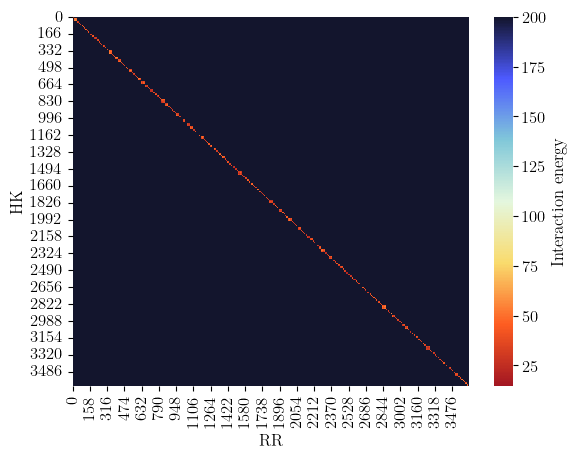

In [46]:
# score_save[score_save == 10000] = 200
# plt.figure()
# ax = sns.heatmap(score_save,cmap=cmap)
# cbar = ax.collections[0].colorbar
# cbar.set_label('Interaction energy')
# plt.ylabel("HK")
# plt.xlabel("RR")
# #plt.title(r"E. coli K-12 MG165, $M_\mathrm{train}=2000$")
# #plt.savefig("./figs/heatmap_energy_ecoliK12.png",dpi=1000)
# plt.savefig("./figs/heatmap_int_test_{family}_{H}_{d}_L_A={L_A}.pdf".format(family=family, H=H, d=d, L_A=L_A))
# plt.show()

In [14]:
correct_scores = df_energy[df_energy['correct'] == True]['score'].values
incorrect_scores = df_energy[df_energy['correct'] == False]['score'].values
incorrect_scores = incorrect_scores[incorrect_scores < def_val]

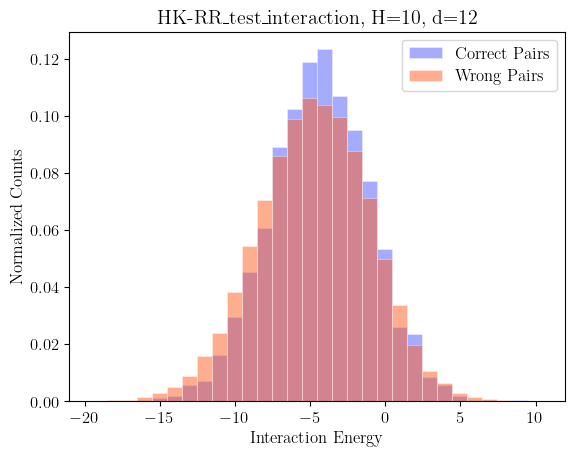

In [15]:
bin_width = 1

min_bins=min(min(correct_scores), min(incorrect_scores))
max_bins=max(max(correct_scores), max(incorrect_scores))
bins=np.arange(min_bins,max_bins+bin_width,bin_width)

plt.figure()
plt.hist(correct_scores, bins=bins, alpha=0.5, label='Correct Pairs', color=mypalette[0], density=True, edgecolor='white', linewidth=0.5)
plt.hist(incorrect_scores, bins=bins, alpha=0.5, label='Wrong Pairs', color=mypalette[1], density=True, edgecolor='white', linewidth=0.5)
plt.xlabel("Interaction Energy")


plt.ylabel("Normalized Counts")
plt.legend()#bbox_to_anchor=(0.5, 0.7))
plt.title("{family}, H={H}, d={d}".format(family=family, H=H, d=d))
plt.savefig('ALE_int_test_energy_scores_species_{family}_{H}_{d}_L_A={L_A}.pdf'.format(family=family, H=H, d=d, L_A=L_A))
plt.show()

### Full energy calculation

In [36]:
label_B_full, score_full, correct_energies_full, score_save_full = prep_spectrum_plots_energy_species_full(MSA_A_label,MSA_B_label,A, V)
df_energy_full=pd.DataFrame({'label B':label_B_full, 'score':score_full, 'correct':correct_energies_full})

tokenized seqs
energy calculated


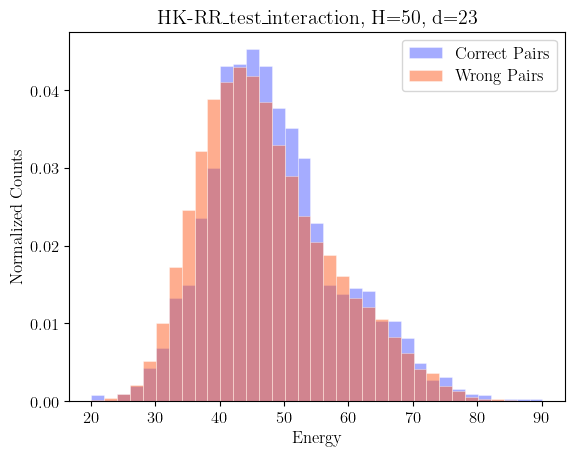

In [18]:
correct_scores_full = df_energy_full[df_energy_full['correct'] == True]['score'].values
incorrect_scores_full = df_energy_full[df_energy_full['correct'] == False]['score'].values
incorrect_scores_full = incorrect_scores_full[incorrect_scores_full < def_val]

bin_width_full = 2

min_full=min(min(correct_scores_full), min(incorrect_scores_full))
max_full=max(max(correct_scores_full), max(incorrect_scores_full))
bins_full=np.arange(min_full,max_full+bin_width_full,bin_width_full)

plt.figure()
plt.hist(correct_scores_full, bins=bins_full, alpha=0.5, color=mypalette[0], label='Correct Pairs', density=True, edgecolor='white', linewidth=0.5)
plt.hist(incorrect_scores_full, bins=bins_full, alpha=0.5, color=mypalette[1], label='Wrong Pairs', density=True, edgecolor='white', linewidth=0.5)
plt.xlabel("Energy")
plt.ylabel("Normalized Counts")
plt.legend()#bbox_to_anchor=(0.5, 0.7))
plt.title("{family}, H={H}, d={d}".format(family=family, H=H, d=d))
plt.savefig('int_test_full_energy_scores_species_{family}_{H}_{d}_L_A={L_A}.pdf'.format(family=family, H=H, d=d, L_A=L_A))
plt.show()

# With Masks

In [ ]:
H = 32
d = 23
loss_type = 'without_J'
family = 'HK-RR'

epochs = 300
cwd = os.getcwd()

folder_mask="HK-RR_174_train_masks"
K_mask = read_tensor_from_txt( cwd +"/results/"+folder_mask+"/K_tensor.txt")
Q_mask = read_tensor_from_txt( cwd +"/results/"+folder_mask+"/Q_tensor.txt") 
V_mask = read_tensor_from_txt( cwd +"/results/"+folder_mask+"/V_tensor.txt")

V_mask=V_mask[:,1:,1:]
A_mask=attention_heads_masks(Q_mask, K_mask, V_mask, sym=True, head_mask=64, H1=11, H2=26)

V_mask = np.array(V_mask)
A_mask = np.array(A_mask)

In [32]:
label_B_mask, score_mask, correct_energies_mask, score_save_mask = prep_spectrum_plots_energy_species(MSA_A_label,MSA_B_label,A_mask, V_mask)
df_energy_mask=pd.DataFrame({'label B':label_B_mask, 'score':score_mask, 'correct':correct_energies_mask})

tokenized seqs
energy calculated


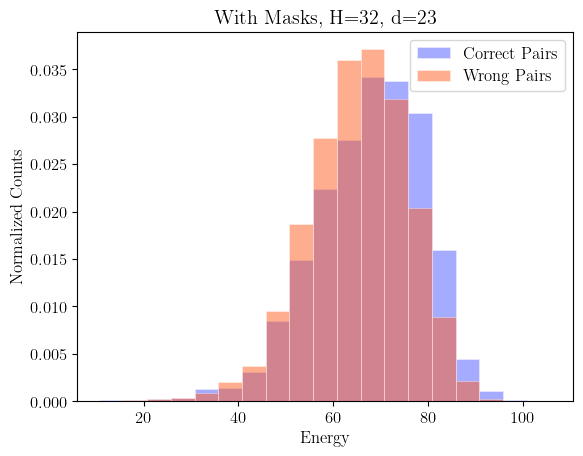

In [33]:
correct_scores_mask = df_energy_mask[df_energy_mask['correct'] == True]['score'].values
incorrect_scores_mask = df_energy_mask[df_energy_mask['correct'] == False]['score'].values
incorrect_scores_mask = incorrect_scores_mask[incorrect_scores_mask < def_val]

bin_width_mask = 5

min_mask=min(min(correct_scores_mask), min(incorrect_scores_mask))
max_mask=max(max(correct_scores_mask), max(incorrect_scores_mask))
bins_mask=np.arange(min_mask,max_mask+bin_width_mask,bin_width_mask)

plt.figure()
plt.hist(correct_scores_mask, bins=bins_mask, alpha=0.5, color=mypalette[0], label='Correct Pairs', density=True, edgecolor='white', linewidth=0.5)
plt.hist(incorrect_scores_mask, bins=bins_mask, alpha=0.5, color=mypalette[1], label='Wrong Pairs', density=True, edgecolor='white', linewidth=0.5)
plt.xlabel("Energy")
plt.ylabel("Normalized Counts")
plt.legend()#bbox_to_anchor=(0.5, 0.7))
plt.title("With Masks, H={H}, d={d}".format(H=H, d=d))
plt.savefig('mask_energy_scores_species_{family}_{H}_{d}.pdf'.format(family=family, H=H, d=d))
plt.show()

In [34]:
label_B_mask_full, score_mask_full, correct_energies_mask_full, score_save_mask_full = prep_spectrum_plots_energy_species_full(MSA_A_label,MSA_B_label,A_mask, V_mask)
df_energy_mask_full=pd.DataFrame({'label B':label_B_mask_full, 'score':score_mask_full, 'correct':correct_energies_mask_full})


tokenized seqs
energy calculated


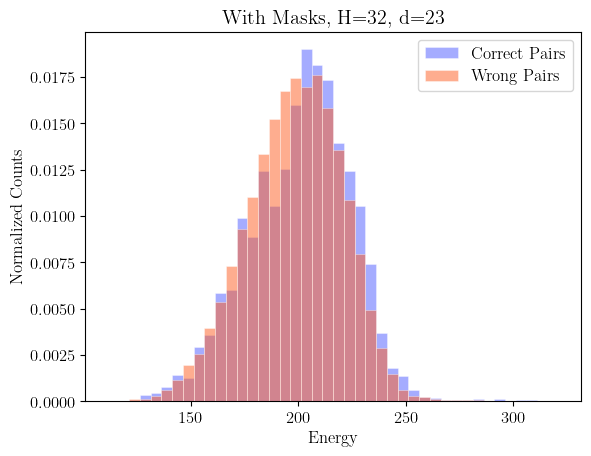

In [35]:
correct_scores_mask_full = df_energy_mask_full[df_energy_mask_full['correct'] == True]['score'].values
incorrect_scores_mask_full = df_energy_mask_full[df_energy_mask_full['correct'] == False]['score'].values
incorrect_scores_mask_full = incorrect_scores_mask_full[incorrect_scores_mask_full < def_val]

bin_width_mask_full = 5

min_mask_full=min(min(correct_scores_mask_full), min(incorrect_scores_mask_full))
max_mask_full=max(max(correct_scores_mask_full), max(incorrect_scores_mask_full))
bins_mask_full=np.arange(min_mask_full,max_mask_full+bin_width_mask_full,bin_width_mask_full)

plt.figure()
plt.hist(correct_scores_mask_full, bins=bins_mask_full, alpha=0.5, color=mypalette[0], label='Correct Pairs', density=True, edgecolor='white', linewidth=0.5)
plt.hist(incorrect_scores_mask_full, bins=bins_mask_full, alpha=0.5, color=mypalette[1], label='Wrong Pairs', density=True, edgecolor='white', linewidth=0.5)
plt.xlabel("Energy")
plt.ylabel("Normalized Counts")
plt.legend()#bbox_to_anchor=(0.5, 0.7))
plt.title("With Masks, H={H}, d={d}".format(H=H, d=d))
plt.savefig('mask_energy_scores_species_full_{family}_{H}_{d}.pdf'.format(family=family, H=H, d=d))
plt.show()